# Training Unet using data for blood vessel segmentation
https://www.kaggle.com/datasets/zionfuo/drive2004?resource=download

## Importing PyTorch and setting up device agnostic code

In [ ]:
# Import PyTorch
import torch
from torch import nn

torch.__version__

'2.3.1+cu121'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data
retina images



In [ ]:
import os
import cv2

In [ ]:
import os
import requests
import zipfile
from pathlib import Path
from google.colab import drive


# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "archive"
image_path2 =image_path / "DRIVE"

# if the image folder does not exist, download it and prepare it..
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download ")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Unzip archive.zip
with zipfile.ZipFile(data_path / "archive.zip", "r") as zip_ref:
  print("Unzipping Retina.zip...")
  zip_ref.extractall(image_path)

data/archive directory already exists... skipping download 
Unzipping Retina.zip...


## Data preparation and data exploration

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its content """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

In [ ]:
walk_through_dir(image_path)

There are 1 directories and 0 images in 'data/archive'. 
There are 2 directories and 0 images in 'data/archive/DRIVE'. 
There are 3 directories and 0 images in 'data/archive/DRIVE/training'. 
There are 0 directories and 20 images in 'data/archive/DRIVE/training/1st_manual'. 
There are 0 directories and 20 images in 'data/archive/DRIVE/training/images'. 
There are 0 directories and 20 images in 'data/archive/DRIVE/training/mask'. 
There are 4 directories and 0 images in 'data/archive/DRIVE/test'. 
There are 0 directories and 20 images in 'data/archive/DRIVE/test/2nd_manual'. 
There are 0 directories and 20 images in 'data/archive/DRIVE/test/1st_manual'. 
There are 0 directories and 20 images in 'data/archive/DRIVE/test/images'. 
There are 0 directories and 20 images in 'data/archive/DRIVE/test/mask'. 


In [ ]:
# Setup train and testing paths
train_dir = image_path2 / "training"
test_dir = image_path2 / "test"
train_dir, test_dir

(PosixPath('data/archive/DRIVE/training'),
 PosixPath('data/archive/DRIVE/test'))

### Visualizing and image

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all of the training paths for training images and its 1st manual
image_path_list_train = sorted(image_path2.glob("training/*/*.tif"))
image_path_list_train_manual = sorted(image_path2.glob("training/1st_manual/*.gif"))
# image_path_list_train_manual[:]

# 1.5 Get all the testing paths for testing images and its 1st manual
image_path_list_test = sorted(image_path2.glob("test/*/*.tif"))
image_path_list_test_manual = sorted(image_path2.glob("test/1st_manual/*.gif"))
# image_path_list_test_manual[:]

print(f"Train: Raw: {len(image_path_list_train)} - Manually segmented: {len(image_path_list_train_manual)}")
print(f"Test: Raw: {len(image_path_list_test)} - Manually segemented: {len(image_path_list_test_manual)}")

Train: Raw: 20 - Manually segmented: 20
Test: Raw: 20 - Manually segemented: 20


Random image path data/archive/DRIVE/training/images/24_training.tif
Image class: training
Image height: 584
Image width: 565


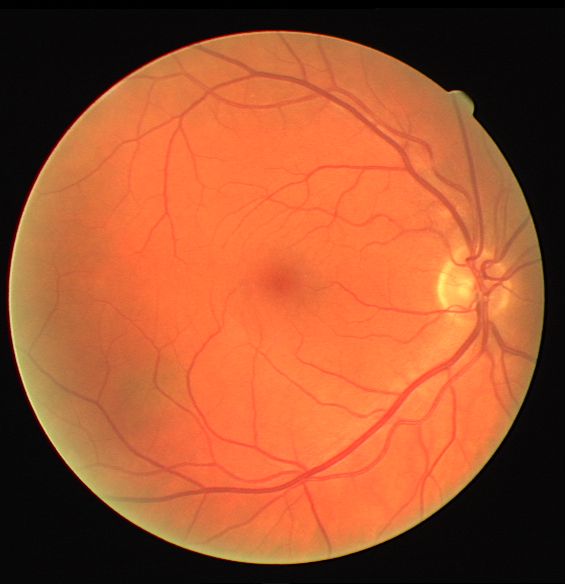

In [ ]:
# 2. Pick a random image path
random_image_path_train = random.choice(image_path_list_train)
random_image_path_test = random.choice(image_path_list_test)

#3 Get image class from path name
image_class_train = random_image_path_train.parent.parent.stem
image_class_test = random_image_path_test.parent.parent.stem
# print(image_class_train), print(image_class_test)

# 4. Open image
img_train = Image.open(random_image_path_train)
img_test = Image.open(random_image_path_test)

# 5. Metadata printout
print(f"Random image path {random_image_path_train}")
print(f"Image class: {image_class_train}")
print(f"Image height: {img_train.height}")
print(f"Image width: {img_train.width}")
img_train

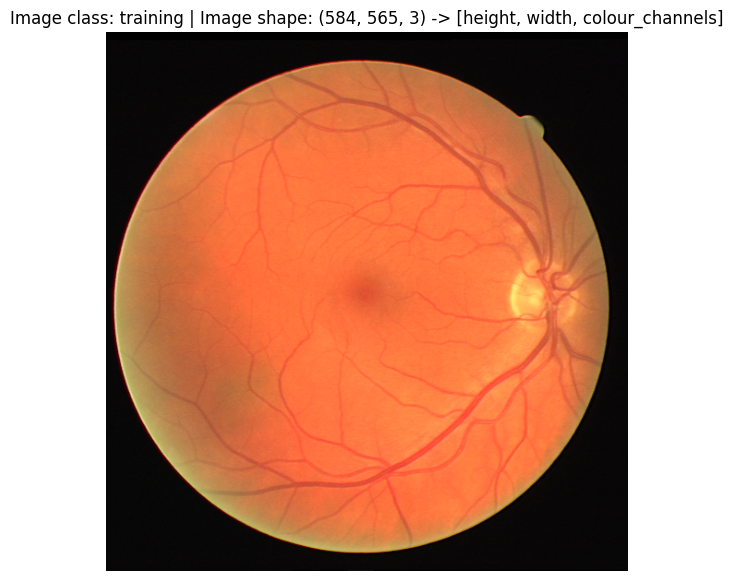

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img_train)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class_train} | Image shape: {img_as_array.shape} -> [height, width, colour_channels]")
plt.axis(False);

## Tranforming the data
1. Turning the data into tensors.
2. Reshape the images so it could pass through the Unet

In [ ]:
import torch
from torch.utils.data import dataloader
from torchvision import datasets, transforms
import os
import numpy as np
import cv2 #
from glob import glob
from tqdm import tqdm
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate

## Creating directories to save the augmented data

In [ ]:
# Define the paths you want to create
paths_to_create = [
    image_path2 / "new_data" / "train" / "image",
    image_path2 / "new_data" / "train" / "mask",
    image_path2 / "new_data" / "test" / "image",
    image_path2 / "new_data" / "test" / "mask"
]

# Check and create each directory if it does not already exist
for path in paths_to_create:
    if path.is_dir():
        print(f"{path} directory already exists... skipping creation")
    else:
        print(f"{path} does not exist, creating one...")
        path.mkdir(parents=True, exist_ok=True)

print("Directory check and creation process completed.")

data/archive/DRIVE/new_data/train/image does not exist, creating one...
data/archive/DRIVE/new_data/train/mask does not exist, creating one...
data/archive/DRIVE/new_data/test/image does not exist, creating one...
data/archive/DRIVE/new_data/test/mask does not exist, creating one...
Directory check and creation process completed.


In [ ]:
# # Write a transform for image
# data_transform = transforms.Compose([
#     # Resize our images to 572x572
#     transforms.Resize(size=(572, 572)),
#     # Flip the images randomly on the horizontal
#     transforms.RandomHorizontalFlip(p=0.5),
#     # Turn the images in toe greyscale so just 1 channel from 3
#     transforms.Grayscale(num_output_channels=1),
#     # Turn the image into a torch.Tensor
#     transforms.ToTensor()
# ])

In [ ]:
# Data augmentation function
def augment_data(images, masks, save_path, augment=True):
    size = (512, 512)

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):

        # Convert PosixPath to string and extract the name
        name = x.name.split(".")[0]

        # Reading image and mask
        x = cv2.imread(str(x), cv2.IMREAD_COLOR)  # Convert PosixPath to string before reading
        y = imageio.mimread(str(y))[0]  # Convert PosixPath to string before reading

        if augment == True:
          aug = HorizontalFlip(p=1.0)
          augmented = aug(image=x, mask=y)
          x1 = augmented["image"]
          y1 = augmented["mask"]

          aug = VerticalFlip(p=1.0)
          augmented = aug(image=x, mask=y)
          x2 = augmented["image"]
          y2 = augmented["mask"]

          aug = Rotate(limit=45, p=1.0)
          augmented = aug(image=x, mask=y)
          x3 = augmented["image"]
          y3 = augmented["mask"]

          X = [x, x1, x2, x3]
          Y = [y, y1, y2, y3]

        else:
          X = [x]
          Y = [y]

        index = 0
        for i, m in zip(X, Y):
          i = cv2.resize(i, size)
          m = cv2.resize(m, size)

          tmp_image_name = f"{name}_{index}.png"
          tmp_mask_name = f"{name}_{index}.png"

          image_path = os.path.join(save_path, "image", tmp_image_name)
          mask_path = os.path.join(save_path, "mask", tmp_mask_name)

          cv2.imwrite(image_path, i)
          cv2.imwrite(mask_path, m)

          index += 1

In [ ]:
# Augmented data with only reseizing for training
augment_data(images=image_path_list_train,
             masks=image_path_list_train_manual,
             save_path= image_path2 / "new_data" / "train",
             augment=False)

# Augmented data with transformation for training
augment_data(images=image_path_list_train,
             masks=image_path_list_train_manual,
             save_path= image_path2 / "new_data" / "train",
             augment=True)

100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


In [ ]:
# Augmented data for the test data, no augmentation needed
augment_data(images=image_path_list_test,
             masks=image_path_list_test_manual,
             save_path= image_path2 / "new_data" / "test",
             augment=False)

100%|██████████| 20/20 [00:00<00:00, 30.30it/s]


## U-Net Model
to get segmentation tasks
1 channel needed since it is a binary segmentation problem

In [ ]:
import torch
import torch.nn as nn

# Double conv layer
def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),  # Added padding to maintain spatial dimensions
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),  # Added padding to maintain spatial dimensions
        nn.ReLU(inplace=True),
    )
    return conv

# Forward encoder and decoder layer
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)  # Adjusted for 3 input channels previous one was a grey scale picture
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                                             kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(in_c=1024, out_c=512)

        self.up_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256,
                                             kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(in_c=512, out_c=256)

        self.up_trans_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128,
                                             kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(in_c=256, out_c=128)

        self.up_trans_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                             kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(in_c=128, out_c=64)

        # Output layer with 1 output channel for binary segmentation
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def forward(self, image):
        # Encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)

        # Decoder
        x = self.up_trans_1(x9)
        x = self.up_conv_1(torch.cat([x, x7], dim=1))

        x = self.up_trans_2(x)
        x = self.up_conv_2(torch.cat([x, x5], dim=1))

        x = self.up_trans_3(x)
        x = self.up_conv_3(torch.cat([x, x3], dim=1))

        x = self.up_trans_4(x)
        x = self.up_conv_4(torch.cat([x, x1], dim=1))

        x = self.out(x)
        # print(x.size())  # Output shape: should be [2, 1, 512, 512]
        return x

In [ ]:
# Testing the model with a random tensor
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = UNet().to(device)
image = torch.randn(size=(2, 3, 512, 512)).to(device)
output = model_0(image).to(device)
print(output.shape)

torch.Size([2, 1, 512, 512])


### Using torchinfo to understand the shapes of our model

In [ ]:
# # Install torchnfor, import if its available
# try:
#   import torchinfo
# except:
#   !pip install torchinfo
#   import torchinfo

# from torchinfo import summary
# summary(model_0, input_size=[2, 3, 512, 512])

## setting up dataset and data loader

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import glob

In [ ]:
# New training dataset path
train_image = sorted(image_path2.glob("new_data/train/image/*"))
train_mask = sorted(image_path2.glob("new_data/train/mask/*"))
# train_image[:5], train_mask[:5]
# len(train_image), len(train_mask)

In [ ]:
# New testing dataset path
test_image = sorted(image_path2.glob("new_data/test/image/*"))
test_mask = sorted(image_path2.glob("new_data/test/mask/*"))
# test_image[:5], test_mask[:5]
# len(test_image), len(test_mask)

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class DiceLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):

#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = torch.sigmoid(inputs)

#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)

#         intersection = (inputs * targets).sum()
#         dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

#         return 1 - dice

# class DiceBCELoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceBCELoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):

#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = torch.sigmoid(inputs)

#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)

#         intersection = (inputs * targets).sum()
#         dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
#         BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
#         Dice_BCE = BCE + dice_loss

#         return Dice_BCE

In [ ]:
# Hyperparameters
H = 512
W = 512
size = (H, W)
batch_size = 2
lr = 0.001

In [ ]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

In [ ]:
# Dataset and loader
train_dataset = DriveDataset(train_image, train_mask)
test_dataset = DriveDataset(test_image, test_mask)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers =os.cpu_count()
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers =os.cpu_count()
)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)

        # Forward pass
        y_pred = model(X)  # y_pred should have shape [batch_size, 1, 512, 512]

        # Calculate loss
        loss = loss_fn(y_pred, y)  # Both y_pred and y should have shape [batch_size, 1, 512, 512]
        train_loss += loss.item()

        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy (for binary classification)
        y_pred_class = torch.round(torch.sigmoid(y_pred))
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred_class)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)

            # 1. Forward pass
            test_pred_logits = model(X).squeeze(1)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate accuracy (for binary classification)
            test_pred_labels = torch.round(torch.sigmoid(test_pred_logits))
            test_acc += accuracy_fn(y, test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


## Creating train() function by combining train and test step

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "trained_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss" : [],
             "test_acc": []
             }

  """ Training the model """
  best_test_loss = float("inf")

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn =loss_fn,
                                    device=device)
    """ Saving the model """
    if test_loss < best_test_loss:
      data_str = (f"Test loss improved from {best_test_loss:2.4f} to {train_loss}")
      print(data_str)

      best_test_loss = test_loss
      torch.save(model.state_dict(), f=MODEL_SAVE_PATH)

    # 4. Print out what is happening
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss: .4f} | Test acc: {test_acc:.4f} ")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

## Train and evaluate model on unet

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Setup loss function and optimizer
model_0 = UNet().to(device)

loss_fn = DiceBCELoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print our how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/20 [01:11<?, ?it/s]


KeyboardInterrupt: 

## Evaluation of model and making prediction on images

In [ ]:
import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

In [ ]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

In [ ]:
import torch
from pathlib import Path

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Make sure this UNet class is the SAME as the one used to save the model
model = build_unet().to(device)

# Load the model weights
MODEL_SAVE_PATH = Path("models/trained_model.pth")
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))

<All keys matched successfully>

In [ ]:
import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

In [ ]:
def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

In [ ]:
from pathlib import Path

results = Path("results")
results.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

In [ ]:
import time
import torch
import numpy as np
import cv2
from tqdm import tqdm
from operator import add

metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
time_taken = []

with torch.inference_mode():
    for i, (x, y) in tqdm(enumerate(zip(test_image, test_mask)), total=len(test_image)):
        """ Extract the name """
        name = x.name.split(".")[0]
        # name = x.split("/")[-1].split(".")[0]

        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)  # (512, 512, 3)
        # image = cv2.resize(image, size)
        x = np.transpose(image, (2, 0, 1))  # (3, 512, 512)
        x = x / 255.0
        x = np.expand_dims(x, axis=0)  # (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        """ Reading mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  # (512, 512)
        # mask = cv2.resize(mask, size)
        y = np.expand_dims(mask, axis=0)  # (1, 512, 512)
        y = y / 255.0
        y = np.expand_dims(y, axis=0)  # (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        """ Prediction and Calculating FPS"""
        start_time = time.time()
        pred_y = model(x)
        pred_y = torch.sigmoid(pred_y)
        total_time = time.time() - start_time
        time_taken.append(total_time)

        score = calculate_metrics(y, pred_y)
        metrics_score = list(map(add, metrics_score, score))
        pred_y = pred_y[0].cpu().numpy()  # (1, 512, 512)
        pred_y = np.squeeze(pred_y, axis=0)  # (512, 512)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)

        """ Saving masks """
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((image.shape[0], 10, 3)) * 128  # Adjusted to match the image's height

        cat_images = np.concatenate([image, line, ori_mask, line, pred_y * 255], axis=1)
        cv2.imwrite(f"results/{name}.png", cat_images)

jaccard = metrics_score[0] / len(test_image)
f1 = metrics_score[1] / len(test_image)
recall = metrics_score[2] / len(test_image)
precision = metrics_score[3] / len(test_image)
acc = metrics_score[4] / len(test_image)
print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

fps = 1 / np.mean(time_taken)
print("FPS: ", fps)

100%|██████████| 20/20 [03:46<00:00, 11.32s/it]

Jaccard: 0.6664 - F1: 0.7996 - Recall: 0.7899 - Precision: 0.8134 - Acc: 0.9656
FPS:  0.09238698550800621


## Testing on an en face image ?


In [ ]:
# Define the paths you want to create
paths_to_create = [
    image_path2 / "en_face_img"
]

# Check and create each directory if it does not already exist
for path in paths_to_create:
    if path.is_dir():
        print(f"{path} directory already exists... skipping creation")
    else:
        print(f"{path} does not exist, creating one...")
        path.mkdir(parents=True, exist_ok=True)

print("Directory check and creation process completed.")

data/archive/DRIVE/en_face_img does not exist, creating one...
Directory check and creation process completed.


In [ ]:
test_image_2 = image_path2 / "en_face_img"
test_image_2 = sorted(glob(str(test_image_2 / "*.png")))
test_image_2

['data/archive/DRIVE/en_face_img/en_face.png']

In [ ]:
time_taken = []

with torch.inference_mode():
    for i, x in tqdm(enumerate(test_image_2), total=len(test_image_2)):
        """ Using a fixed name for saving """
        name = "test_1_image"

        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)  # (512, 512, 3)
        # image = cv2.resize(image, size)
        x = np.transpose(image, (2, 0, 1))  # (3, 512, 512)
        x = x / 255.0
        x = np.expand_dims(x, axis=0)  # (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        """ Prediction and Calculating FPS """
        start_time = time.time()
        pred_y = model(x)
        pred_y = torch.sigmoid(pred_y)
        total_time = time.time() - start_time
        time_taken.append(total_time)

        pred_y = pred_y[0].cpu().numpy()  # (1, 512, 512)
        pred_y = np.squeeze(pred_y, axis=0)  # (512, 512)
        pred_y = pred_y > 0.5
        pred_y = np.array(pred_y, dtype=np.uint8)

        """ Saving the predicted mask """
        pred_y = pred_y * 255  # Convert to binary mask
        line = np.ones((image.shape[0], 10, 3)) * 128  # Adjusted to match the image's height

        cat_images = np.concatenate([image, line, np.stack([pred_y] * 3, axis=-1)], axis=1)
        cv2.imwrite(f"results/{name}_pred.png", cat_images)

fps = 1 / np.mean(time_taken)
print("FPS: ", fps)

100%|██████████| 1/1 [00:11<00:00, 11.71s/it]

FPS:  0.0859104269080303
